<a href="https://colab.research.google.com/github/WforGodot/wordle_solver/blob/main/Wordle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from time import time

In [15]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/Early Code/Wordle/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = "/content/drive/MyDrive/Early Code/Wordle/words.txt"

with open(filename) as f:
    word_list = f.readlines()
word_list = [word[:5] for word in word_list]

In [4]:
filename2 = "/content/drive/MyDrive/Early Code/Wordle/target.txt"

with open(filename2) as f:
    word_target = f.readlines()
word_target = [word[:5] for word in word_target]

In [5]:
word_array = np.zeros((len(word_list), 5))
target_array = np.zeros((len(word_target), 5))

for i in range(len(word_list)):
    word_array[i] = [ord(character)-96 for character in word_list[i]]
    
for i in range(len(word_target)):
    target_array[i] = [ord(character)-96 for character in word_target[i]]

In [6]:
scoring = [2, 6, 18, 54, 162, 1, 3, 9, 27, 81, 1, 3, 9, 27, 81, 1, 3, 9, 27, 81, 1, 3, 9, 27, 81]
def simi_scores(target_vec, word_array):
    target_vec2 = np.concatenate((target_vec, target_vec[1:], target_vec[:1], target_vec[2:], 
                                  target_vec[:2], target_vec[3:], target_vec[:3], target_vec[4:], target_vec[:4]))
    word_array2 = np.concatenate((word_array, word_array, word_array, word_array, word_array), axis = 1)
    word_array2 = target_vec2 - word_array2
    word_array2 = (word_array2 == 0)
    simi_scores = word_array2@scoring
    return simi_scores

In [7]:
similarity_array = np.zeros((len(word_target), len(word_list)))
for i in range(len(word_target)):
    similarity_array[i] = simi_scores(target_array[i], word_array)
simi_list = [similarity_array[i].tolist() for i in range(len(similarity_array))]

In [8]:
def find_word(word):
    return word_list.index(word)

def find_target(target):
    return word_target.index(target)

def filter(test_word, score, original):
    word = find_word(test_word)
    return [i for i in original if similarity_array[i, word] == score]

def display(list):
    words = []
    for i in list:
        words.append(word_target[i])
    return words

def filter_by_matrix(word, score, original):
    simi_list = [vec for vec in original if vec[word] == score]
    return simi_list

def return_filtered_length(word, score, original):
    return len([1 for vec in original if vec[word] == score])

def length_heuristic(length):
    if length < 2:
        return 0
    elif length < 10:
        return length
    elif length < 20:
        return length*1.3 #(2-check_for_split(simi_list))
    else: 
        return length*1.7
    
def find_word_from_vec(vec):
    return find_word(word_target[simi_list.index(vec)])

In [9]:
def check_for_split(simi_list):
    if len(simi_list) == 0:
        return 1
    array = np.transpose(np.array(simi_list))
    lengths = [len(np.unique(array[i])) for i in range(len(word_list))]
    return max(lengths)/len(simi_list)

In [25]:
lengths = []
split = []
for j in range(243):
    ori = filter_by_matrix(20, j, simi_list)
    for i in range(243):
        x = filter_by_matrix(i, i, ori)
        if len(x) < 50:
            lengths.append(len(x))
            split.append(check_for_split(x))

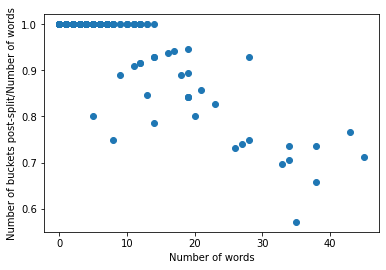

In [26]:
import matplotlib.pyplot as plt

plt.xlabel('Number of words')
plt.ylabel('Number of buckets post-split/Number of words')
plt.scatter(lengths, split)
plt.show()

In [31]:
check = len(word_list)
def best_next_word_matrix(original):
    best_word = "None!"
    
    if len(original) == 0:
        return best_word, 0
    
    matching_words = [find_word_from_vec(vec) for vec in original]
    matching_scores = np.array([i in matching_words for i in range(check)])
    scores = [sum([length_heuristic(return_filtered_length(i, j, original)) for j in range(243)]) for i in range(check)]
    scores_np = np.array(scores) - matching_scores
    #best = np.argmin(scores_np)
    
    ind = np.argpartition(scores_np, 9)[:10]
    best_score = 10000
    #scores2 = []
    for x in ind:
        score = 0
        for j in range(243):
            simi_list = filter_by_matrix(x, j, original)
            length = len(simi_list)
            if length < 2:
                continue
            elif length < 6:
                score += length
            else:
                score += (3 - 2*check_for_split(simi_list))*length
        if x in matching_words:
            score -= 1
        #scores2.append(score)
        if score < best_score:
            best_word = word_list[x]
            best_score = score

    return best_word, 1 + best_score/len(original)

In [11]:
def best_next_word_matrix2(original):
    best_score = 10000
    best_word = "None!"
    best_chance = 0
    original_np = np.transpose(np.array(original))
    if len(original) == 0:
        return best_word, 0
    for i in range(1000): #range(len(word_list)):
        chance = 0
        lengths = [length_heuristic(return_filtered_length(i, j, original_np)) for j in range(243)]
        score = sum(lengths)
    
        if score < best_score:
            best_word = word_list[i]
            best_score = score

    return best_word, 1 + best_score/len(original)

In [12]:
def simi_from_colour(list):
    sum = 0
    for i in range(5):
        sum += list[i]*(3**i)
    return sum
def colour_from_simi(simi):
    colour = [0,0,0,0,0]
    for i in [4,3,2,1,0]:
        x = simi//3**i
        simi -= x*3**i
        colour[i] = x
    return colour

In [16]:
def test_first_word(word):
    results = []
    total_score = 0
    y = find_word(word)
    for i in range(243):
        x = filter_by_matrix(y, i, simi_list)
        word_, score = best_next_word_matrix(x)
        total_score += score*len(x)
        results.append((i, word_, score))
        
    try: 
        os.remove(f'{dir}{word}.txt')
    except: 
        None
        
    with open(f'{dir}{word}.txt', 'w') as fp:
        for (i, word_, score) in results:
            fp.write(f"{colour_from_simi(i)}: {word_}, {score}\n")
        fp.close()
    
    return 1 + total_score/len(word_target)

In [17]:
time1 = time()
print(test_first_word('stare'))
print(time() - time1)

2.580561555075594
35.523802042007446


In [21]:
words2 = ['adieu', 'reais', 'ratio', 'irate', 'stain', 'stare', 'ouija', 'audio', 'react', 'sired', 'tears', 'worse', 'atone', 'arise', 'raise', 'pizza']
words = ['rates', 'stare', 'soare', 'later']
time1 = time()
for word in words:
    print(f"{word}:{test_first_word(word)}")
print(f"Time taken:{time() - time1}")

irate:2.4323974082073434
stare:2.4168466522678185
atone:2.4483801295896326
arise:2.458315334773218
raise:2.4457883369330453
Time taken:4406.116089344025


In [27]:
simi_from_colour([1,1,0,0,2])
#colour_from_simi(108)

166

In [28]:
x = filter('stare', 167, range(2315))
y = filter('couth', 108, x)
z = filter('flong', 84, y)
print(display(x))

['sweet', 'smite', 'spite', 'sleet', 'sheet', 'suite', 'smote']


In [29]:
x = filter_by_matrix(find_word('stare'), 167, simi_list)
y = filter_by_matrix(find_word('couth'), 108, x)

In [32]:
print(best_next_word_matrix(x))

('hilum', 1.0)
